# Asset Allocation Using K_mean Clustering

[Process]

- K-mean clustering으로 2023년, 2022년, 2021년 수익률, 변동성 기준으로 군집화 --> 교집합이 적음 --> 3가지 해결방안 메모. --> 혹은 아래의 Modularity Network도 적용해봄.

- Modularity Network으로 2023년 수익률, 변동성 기준으로  군집화 후 모멘텀 종목 선정 --> 벤치마크를 2.5배 가량 상회하는 성과 --> 이번엔 모멘텀이 아닌 밸류지표 적용 방안 고민.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import Model Packages
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics
from pykrx import stock
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

# K-mean clustering

# 1) 2023년도 (y-1) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_1st_year : 2023년 데이터

In [122]:
file_path = ('kospi200_stocks.xlsx')
df = pd.read_excel(file_path, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트

data = df.iloc[14:].reset_index(drop=True) # 14번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정


data = data.rename(columns={data.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data['date'] = pd.to_datetime(data['date'], errors='coerce')  # 날짜 형식 변환

# 첫 번째 열을 인덱스로 설정하고 해당 열 제거
data = data.set_index(data.columns[0])

# 인덱스를 datetime 형식으로 변환
data.index = pd.to_datetime(data.index, errors='coerce')

# # MultiIndex 생성 (Code, Date)
data.columns.name = 'Code'  # 종목 코드에 이름 설정
data.index.name = 'Date'    # 날짜 인덱스에 이름 설정

dataset_1st_year = data.loc['2023-01-01':'2023-12-31',:]
dataset_1st_year.head(10)

Code,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,55300,75000,435500,821000,151000,160500,59300,48500,276500,35200,...,17000,10450,146500,21900,14350,7390,605000,15400,28900,36450
2023-01-02,55500,75700,446000,827000,157000,160000,61500,47600,272000,34300,...,16600,10352,142000,21450,14450,7150,584000,14750,28900,36150
2023-01-03,55400,75600,440500,803000,159000,159000,62400,49050,272000,35000,...,16300,10499,146500,21150,14800,7260,583000,14450,29600,36550
2023-01-04,57800,81000,443000,794000,160500,160500,62000,50500,274500,36400,...,16500,10645,150000,20900,14700,7310,613000,15150,28900,37050
2023-01-05,58200,81400,433500,808000,159000,163000,61100,53900,278500,39450,...,16500,10401,141000,20950,14600,7440,610000,14700,27850,37150
2023-01-06,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-07,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-08,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-09,60700,86000,464000,812000,164000,166000,64100,57200,289000,40350,...,17050,11036,147000,21300,15150,7710,624000,15500,30200,38300


## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려)

→ 수익률(return)과 변동성(volatility)이 같은 그룹으로 클러스터링 → 동일한 움직임을 가져가는 종목군집을 새롭게 만들 수 있음

각 그룹(A, B, C) 에서 변동성이 가장 적고 수익이 상승하는 군집 각 선택

In [123]:
# N/A값 확인
print('Null Values =',dataset_1st_year.isnull().values.any())

Null Values = True


In [124]:
# 결측치 30%이상인 종목 제거
missing_fractions_1st_year = dataset_1st_year.isnull().mean().sort_values(ascending=False)
drop_list_1st_year = sorted(list(missing_fractions_1st_year[missing_fractions_1st_year > 0.3].index))
dataset_1st_year.drop(labels=drop_list_1st_year, axis=1, inplace=True)
dataset_1st_year.shape

(365, 197)

In [125]:
# Null값 처리
dataset_1st_year = dataset_1st_year.fillna(method='ffill')
# dataset_1st_year.isnull().sum()

In [126]:
dataset_1st_year.head()

Code,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,55300,75000,435500,821000,151000,160500,59300,48500,276500,35200,...,17000,10450,146500,21900,14350,7390,605000,15400,28900,36450
2023-01-02,55500,75700,446000,827000,157000,160000,61500,47600,272000,34300,...,16600,10352,142000,21450,14450,7150,584000,14750,28900,36150
2023-01-03,55400,75600,440500,803000,159000,159000,62400,49050,272000,35000,...,16300,10499,146500,21150,14800,7260,583000,14450,29600,36550
2023-01-04,57800,81000,443000,794000,160500,160500,62000,50500,274500,36400,...,16500,10645,150000,20900,14700,7310,613000,15150,28900,37050
2023-01-05,58200,81400,433500,808000,159000,163000,61100,53900,278500,39450,...,16500,10401,141000,20950,14600,7440,610000,14700,27850,37150


In [127]:
returns_1st_year = pd.DataFrame(dataset_1st_year.pct_change().mean() * len(dataset_1st_year))
returns_1st_year.columns = ['Returns']
returns_1st_year['Volatility'] = dataset_1st_year.pct_change().std() * np.sqrt(len(dataset_1st_year))
data_1st_year = returns_1st_year

전 종목에 대한 수익률과 변동성을 스캐일링 시켜줘야 k-mean이 가능

In [128]:
scaler_1st_year = StandardScaler().fit(data_1st_year)
rescaledDataset_1st_year = pd.DataFrame(scaler_1st_year.fit_transform(data_1st_year),columns = data_1st_year.columns, index = data_1st_year.index)
# summarize transformed data
rescaledDataset_1st_year.head(2)
X_1st_year=rescaledDataset_1st_year
X_1st_year.head(2)

,Returns,Volatility
Code,,
A005930,0.380597,-1.144528
A000660,1.119263,-0.173423


Elbow-method (오차제곱합이 정제되기 시작하는 군집 수)

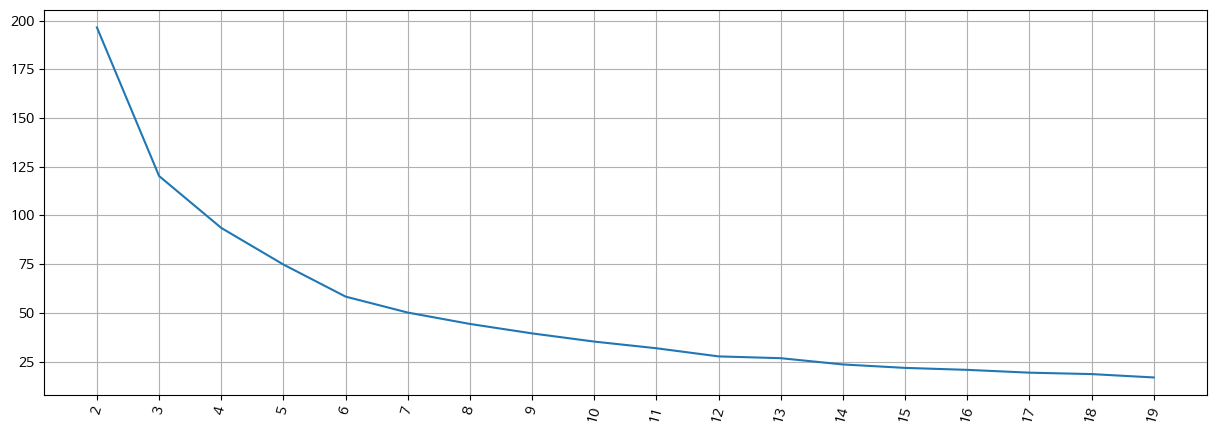

In [129]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_1st_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣기법 (실루엣 점수(-1~1)가 다른 군집에 비해 자신의 군집과 얼마나 유사한지 측정.)

포인트가 높은값이 올바른 군집에 배치되었다고 판단 --> 실루엣 점수(y-축)이 높으면서 평평해지는 부분 선택.

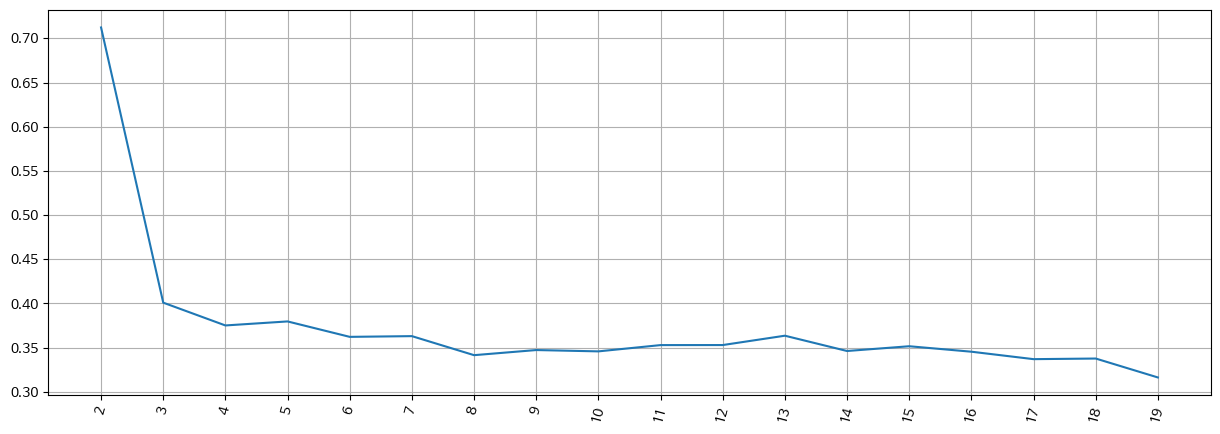

In [130]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_1st_year)
        silhouette_score.append(metrics.silhouette_score(X_1st_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [131]:
nclust=3 # 4
#Fit with k-means
k_means_1st_year = cluster.KMeans(n_clusters=nclust)
k_means_1st_year.fit(X_1st_year)

KMeans(n_clusters=3)

In [132]:
#Extracting labels
target_labels = k_means_1st_year.predict(X_1st_year)

위 과정에서 나온 군집수를 시각화한다

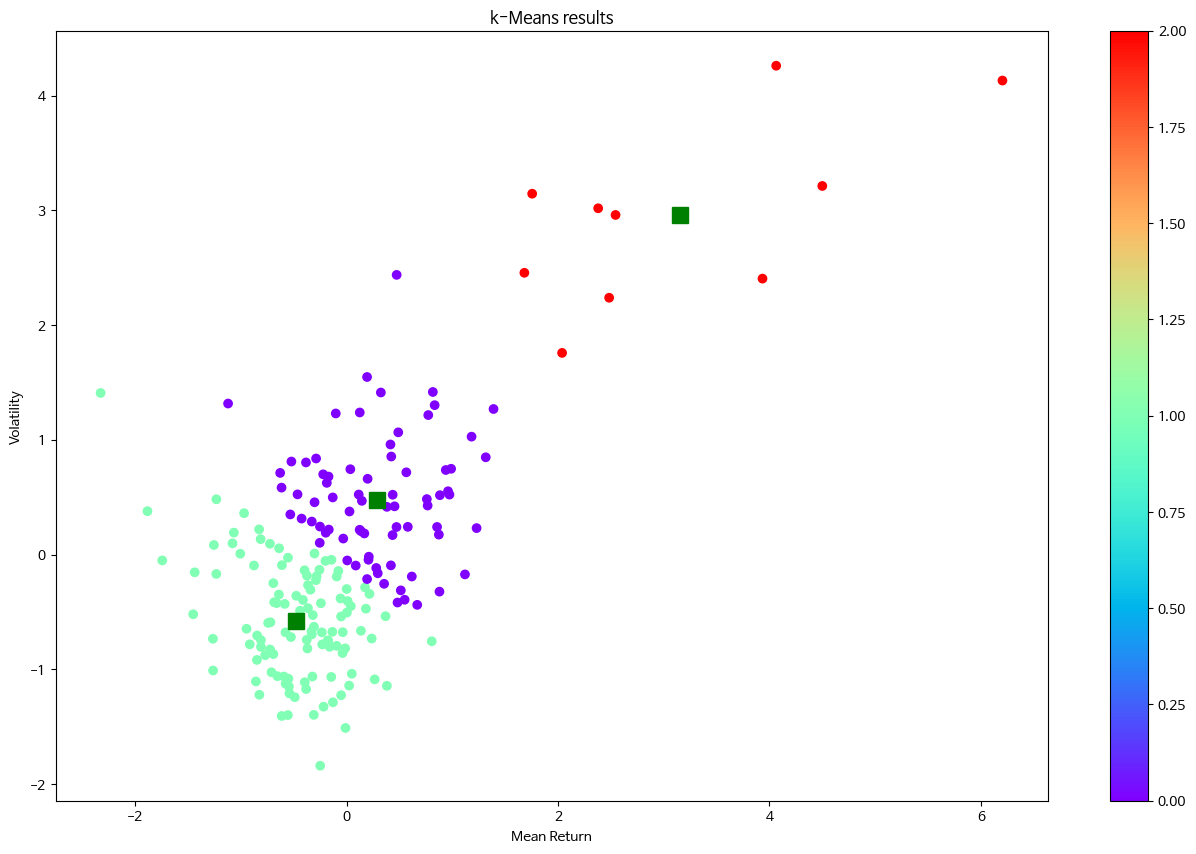

In [133]:
centroids = k_means_1st_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_1st_year.iloc[:,0],X_1st_year.iloc[:,1], c = k_means_1st_year.labels_, cmap ="rainbow", label = X_1st_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

각 군집에 해당하는 종목의 개수를 시각화한다

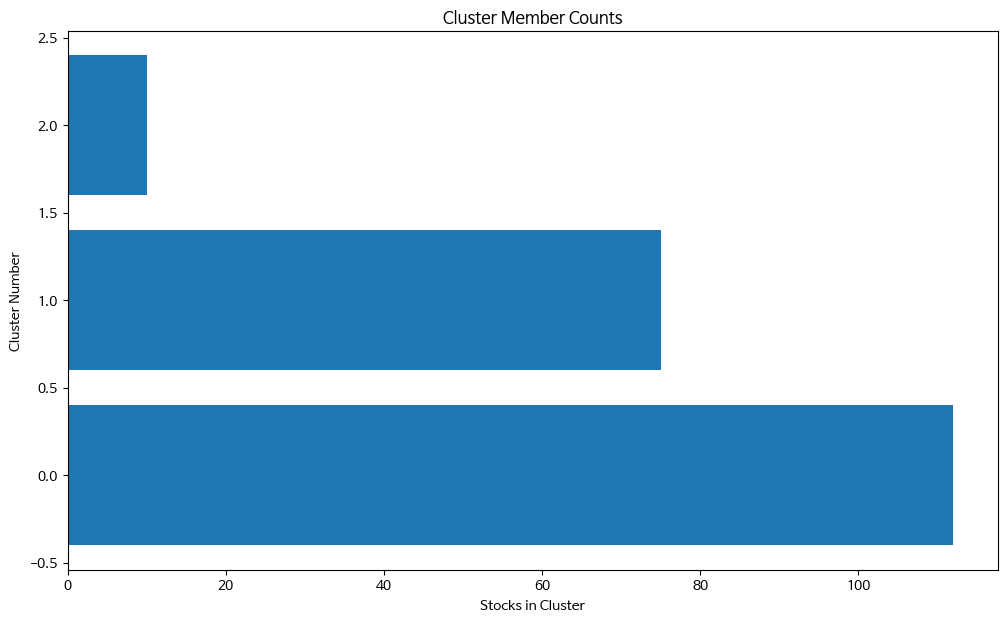

In [134]:
# show number of stocks in each cluster
clustered_series_1st_year = pd.Series(index=X_1st_year.index, data=k_means_1st_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_1st_year.index, data=k_means_1st_year.labels_.flatten())
clustered_series_1st_year = clustered_series_1st_year[clustered_series_1st_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_1st_year.value_counts())), # cluster labels, y axis
    clustered_series_1st_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [135]:
# all stock with its cluster label (including -1)
clustered_series_1st_year = pd.Series(index=X_1st_year.index, data=k_means_1st_year.fit_predict(X_1st_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_1st_year.index, data=k_means_1st_year.fit_predict(X_1st_year).flatten())
clustered_series_1st_year = clustered_series_1st_year[clustered_series_1st_year != -1]
# get the number of stocks in each cluster
counts_1st_year = clustered_series_1st_year.value_counts()

# let's visualize some clusters
cluster_vis_list_1st_year = list(counts_1st_year[(counts_1st_year>1)].index)[::-1]
cluster_vis_list_1st_year

[1, 2, 0]

In [136]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_1st_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 3
Pairs to evaluate: 18072


In [137]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_1st_year[0:min(len(cluster_vis_list_1st_year), 1)]

[1]

<Figure size 2400x1400 with 0 Axes>

많은 군집에서 시각화를 통해 주식의 흐름을 먼저 눈으로 판단해보고

최종적으로 수익률이 0% 이상인 클러스터들만 선택한다.

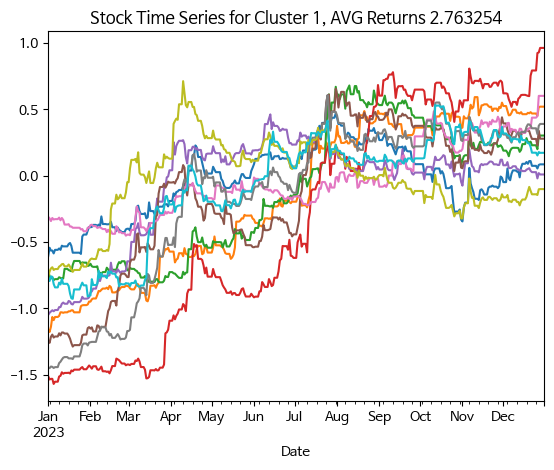

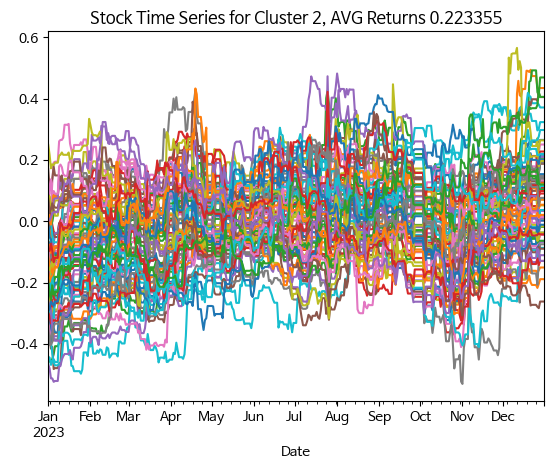

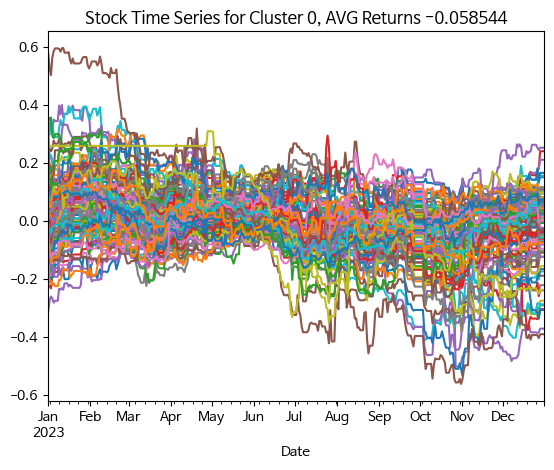

In [138]:
cluster_1st_year_result = []
for clust in cluster_vis_list_1st_year:
    tickers = list(clustered_series_1st_year[clustered_series_1st_year==clust].index)
    means = np.log(dataset_1st_year.loc[:, tickers].mean())
    data = np.log(dataset_1st_year.loc[:, tickers]).sub(means)
    return_value = ((dataset_1st_year.loc[:, tickers].tail(30).mean()-dataset_1st_year.loc[:, tickers].head(30).mean())/dataset_1st_year.loc[:, tickers].head(30).mean()).mean()
    cluster_1st_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show()

In [139]:
df_c_1st_year_result = pd.DataFrame(cluster_1st_year_result, columns=['clust','returns'])
df_c_1st_year_result = df_c_1st_year_result[df_c_1st_year_result['returns'] > 0]
ticker_list_1st_year = []
for idx,row in df_c_1st_year_result.iterrows():
    ticker_list_1st_year = ticker_list_1st_year + (list(clustered_series_1st_year[clustered_series_1st_year==row[0]].index.to_frame(index=False)['Code']))

# 2) 2022년도 (y-2) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_2nd_year : 2022 년 데이터

In [140]:
file_path = ('kospi200_stocks.xlsx')
df = pd.read_excel(file_path, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트
data = df.iloc[14:].reset_index(drop=True) # 14번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
data = data.rename(columns={data.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data['date'] = pd.to_datetime(data['date'], errors='coerce')  # 날짜 형식 변환
data = data.set_index(data.columns[0])
data.index = pd.to_datetime(data.index, errors='coerce')
data.columns.name = 'Code'  # 종목 코드에 이름 설정
data.index.name = 'Date' 

dataset_2nd_year = data.loc['2022-01-01':'2022-12-31',:]
dataset_2nd_year

Code,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,78300,131000,NaN,892432,209000,190729,82200,55000,274500,36800,...,27150,22560,103000,23300,30100,10600,655000,21950,55100,27250
2022-01-02,78300,131000,NaN,892432,209000,190729,82200,55000,274500,36800,...,27150,22560,103000,23300,30100,10600,655000,21950,55100,27250
2022-01-03,78600,128500,NaN,900338,210500,191210,82600,55300,280000,37250,...,27500,22218,100000,23050,29800,10750,653000,21900,54800,27450
2022-01-04,78700,128500,NaN,877607,210000,187357,83500,56400,286500,37600,...,27150,22853,102500,22800,29850,11500,666000,22050,54200,26650
2022-01-05,77400,125500,NaN,850923,213500,180614,85900,56600,295500,37500,...,26550,21584,109000,22800,29700,11750,656000,22150,52800,25700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,58100,77000,457000,828000,158000,170500,64100,51500,292000,37600,...,17750,11182,162000,22800,15050,7800,634000,16650,31300,36300
2022-12-28,56600,76000,436500,830000,154000,165500,60900,49450,291000,35900,...,17600,10841,160500,22350,14550,7720,619000,15900,29900,37200
2022-12-29,55300,75000,435500,821000,151000,160500,59300,48500,276500,35200,...,17000,10450,146500,21900,14350,7390,605000,15400,28900,36450


## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려), (과거 동일 분기 및 최근 트랜드 반영)

In [141]:
print('Null Values =',dataset_2nd_year.isnull().values.any())

Null Values = True


In [142]:
missing_fractions_2nd_year = dataset_2nd_year.isnull().mean().sort_values(ascending=False)
drop_list_2nd_year = sorted(list(missing_fractions_2nd_year[missing_fractions_2nd_year > 0.3].index))
dataset_2nd_year.drop(labels=drop_list_2nd_year, axis=1, inplace=True)
dataset_2nd_year.shape

(365, 197)

In [143]:
dataset_2nd_year = dataset_2nd_year.fillna(method='ffill')

In [144]:
returns_2nd_year = pd.DataFrame(dataset_2nd_year.pct_change().mean() * len(dataset_2nd_year))
returns_2nd_year.columns = ['Returns']
returns_2nd_year['Volatility'] = dataset_2nd_year.pct_change().std() * np.sqrt(len(dataset_2nd_year))
data_2nd_year = returns_2nd_year

In [145]:
# 전종목의 수익률과 변동성을 스케일링
scaler_2nd_year = StandardScaler().fit(data_2nd_year)
rescaledDataset_2nd_year = pd.DataFrame(scaler_2nd_year.fit_transform(data_2nd_year),columns = data_2nd_year.columns, index = data_2nd_year.index)
# summarize transformed data
rescaledDataset_2nd_year.head(2)
X_2nd_year=rescaledDataset_2nd_year
X_2nd_year.head(2)

,Returns,Volatility
Code,,
A005930,-0.622398,-1.323781
A000660,-1.144145,-0.447101


Elbow method

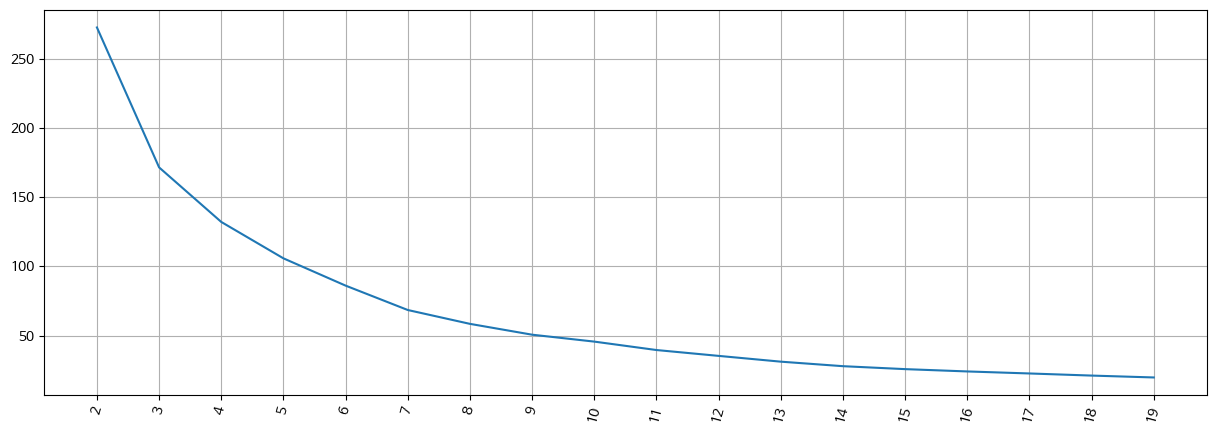

In [146]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_2nd_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣기법

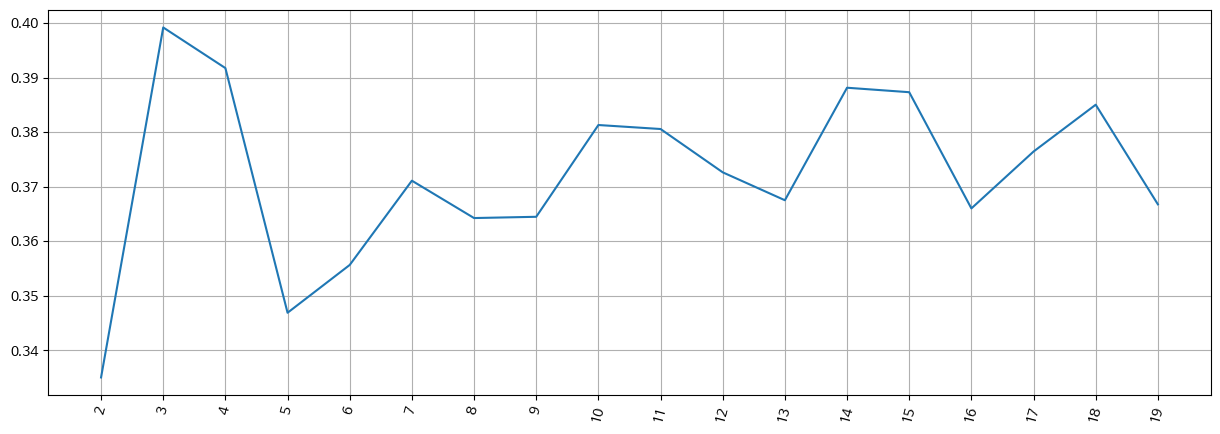

In [147]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_2nd_year)
        silhouette_score.append(metrics.silhouette_score(X_2nd_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [148]:
nclust=3
#Fit with k-means
k_means_2nd_year = cluster.KMeans(n_clusters=nclust)
k_means_2nd_year.fit(X_2nd_year)

KMeans(n_clusters=3)

In [149]:
#Extracting labels
target_labels = k_means_2nd_year.predict(X_2nd_year)

위 과정에서 나온 군집수를 시각화함

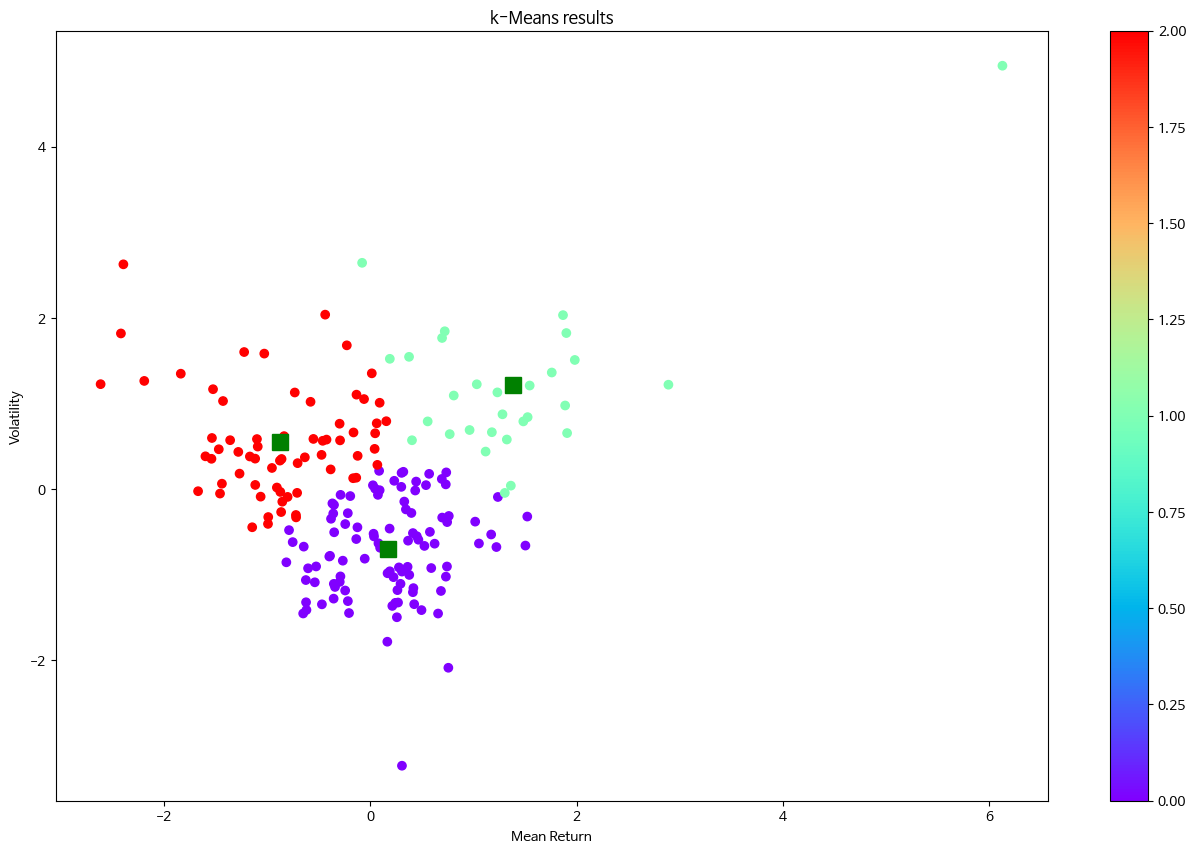

In [150]:
centroids = k_means_2nd_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_2nd_year.iloc[:,0],X_2nd_year.iloc[:,1], c = k_means_2nd_year.labels_, cmap ="rainbow", label = X_2nd_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

각 군집에 해당하는 종목의 개수를 시각화한다

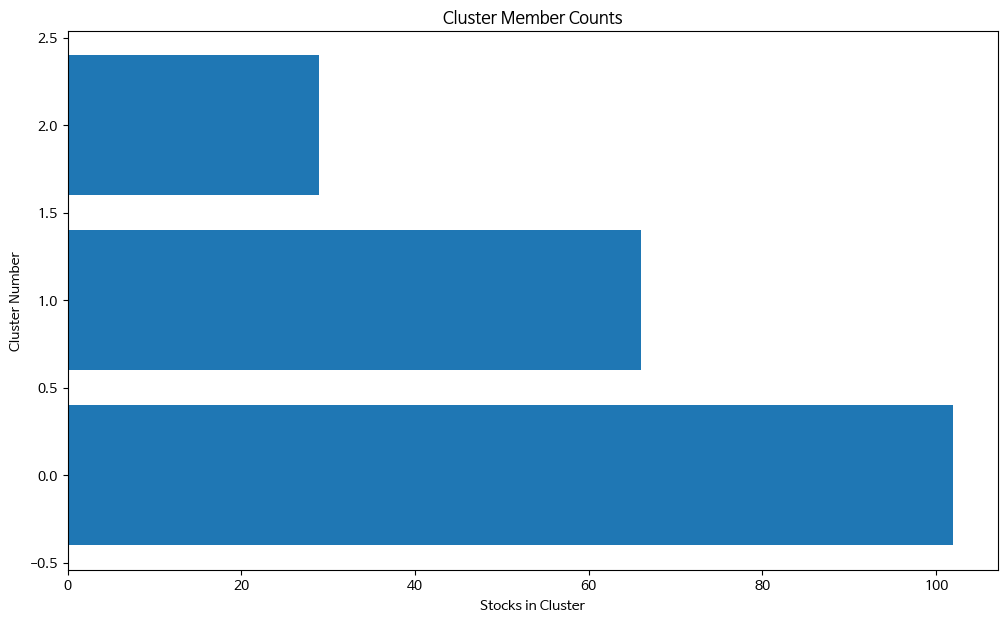

In [151]:
# show number of stocks in each cluster
clustered_series_2nd_year = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.labels_.flatten())
clustered_series_2nd_year = clustered_series_2nd_year[clustered_series_2nd_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_2nd_year.value_counts())), # cluster labels, y axis
    clustered_series_2nd_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [152]:
# all stock with its cluster label (including -1)
clustered_series_2nd_year = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.fit_predict(X_2nd_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_2nd_year.index, data=k_means_2nd_year.fit_predict(X_2nd_year).flatten())
clustered_series_2nd_year = clustered_series_2nd_year[clustered_series_2nd_year != -1]
# get the number of stocks in each cluster
counts_2nd_year = clustered_series_2nd_year.value_counts()

# let's visualize some clusters
cluster_vis_list_2nd_year = list(counts_2nd_year[(counts_2nd_year>1)].index)[::-1]
cluster_vis_list_2nd_year

[0, 1, 2]

In [153]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_2nd_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 3
Pairs to evaluate: 15404


In [154]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_2nd_year[0:min(len(cluster_vis_list_2nd_year), 1)]

[0]

<Figure size 2400x1400 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

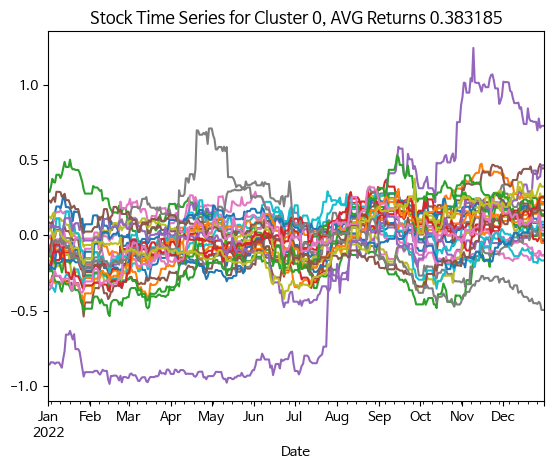

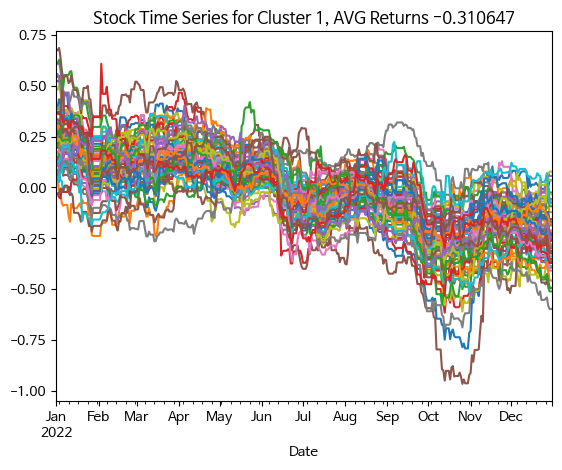

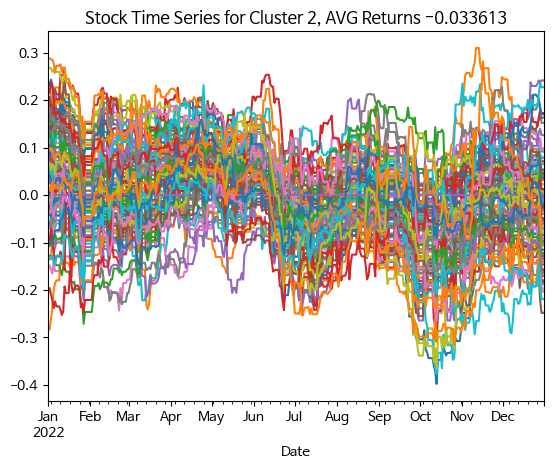

In [155]:
cluster_2nd_year_result = []
for clust in cluster_vis_list_2nd_year:
    tickers = list(clustered_series_2nd_year[clustered_series_2nd_year==clust].index)
    means = np.log(dataset_2nd_year.loc[:, tickers].mean())
    data = np.log(dataset_2nd_year.loc[:, tickers]).sub(means)
    return_value = ((dataset_2nd_year.loc[:, tickers].tail(30).mean()-dataset_2nd_year.loc[:, tickers].head(30).mean())/dataset_2nd_year.loc[:, tickers].head(30).mean()).mean()
    cluster_2nd_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show

In [156]:
df_c_2nd_year_result = pd.DataFrame(cluster_2nd_year_result, columns=['clust','returns'])
df_c_2nd_year_result = df_c_2nd_year_result[df_c_2nd_year_result['returns'] > 0]
ticker_list_2nd_year = []
for idx,row in df_c_2nd_year_result.iterrows():
    ticker_list_2nd_year = ticker_list_2nd_year + (list(clustered_series_2nd_year[clustered_series_2nd_year==row[0]].index.to_frame(index=False)['Code']))

# 3) 2021년도 (y-3) KOSPI, KOSDAQ 모든 종목의 일별 데이터 추출
k-mean_3rd_year : 2021 년 데이터

In [157]:
file_path = ('kospi200_stocks.xlsx')
df = pd.read_excel(file_path, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트
data = df.iloc[14:].reset_index(drop=True) # 14번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
data = data.rename(columns={data.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data['date'] = pd.to_datetime(data['date'], errors='coerce')  # 날짜 형식 변환
data = data.set_index(data.columns[0])
data.index = pd.to_datetime(data.index, errors='coerce')
data.columns.name = 'Code'  # 종목 코드에 이름 설정
data.index.name = 'Date' 

dataset_3rd_year = data.loc['2021-01-01':'2021-12-31',:]
dataset_3rd_year

Code,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,81000,118500,NaN,816333,192000,339412,62400,43400,272000,32050,...,41500,11524,44550,26050,45650,11600,538000,17500,37000,20550
2021-01-02,81000,118500,NaN,816333,192000,339412,62400,43400,272000,32050,...,41500,11524,44550,26050,45650,11600,538000,17500,37000,20550
2021-01-03,81000,118500,NaN,816333,192000,339412,62400,43400,272000,32050,...,41500,11524,44550,26050,45650,11600,538000,17500,37000,20550
2021-01-04,83000,126000,NaN,819298,207500,328540,64000,42450,273000,31550,...,53600,12061,44300,25800,48400,12150,540000,16750,37050,20750
2021-01-05,83900,130500,NaN,822263,209500,335158,63700,43550,285000,32100,...,49550,11866,46000,27050,48300,12950,566000,16550,37000,22400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,80200,126000,NaN,875631,213500,192869,84800,56700,281500,37900,...,27500,20754,101500,23550,29900,10750,672000,21600,52400,25800
2021-12-28,80300,127500,NaN,880572,214000,204215,84500,56800,283500,38150,...,27500,21779,102500,23900,29400,10700,677000,21950,53300,26000
2021-12-29,78800,127000,NaN,879584,212000,193619,83400,55400,279000,37200,...,27400,22023,103500,23350,29850,10700,662000,21550,53200,26200


## 2. K-Mean을 통한 종목 군집화(변동성과 수익성을 고려), (과거 동일 분기 및 최근 트랜드 반영)

In [158]:
print('Null Values =',dataset_3rd_year.isnull().values.any())

Null Values = True


In [159]:
missing_fractions_3rd_year = dataset_3rd_year.isnull().mean().sort_values(ascending=False)
drop_list_3rd_year = sorted(list(missing_fractions_3rd_year[missing_fractions_3rd_year > 0.3].index))
dataset_3rd_year.drop(labels=drop_list_3rd_year, axis=1, inplace=True)
dataset_3rd_year.shape

(365, 187)

In [160]:
dataset_3rd_year = dataset_3rd_year.fillna(method='ffill')

In [161]:
returns_3rd_year = pd.DataFrame(dataset_3rd_year.pct_change().mean() * len(dataset_3rd_year))
returns_3rd_year.columns = ['Returns']
returns_3rd_year['Volatility'] = dataset_3rd_year.pct_change().std() * np.sqrt(len(dataset_3rd_year))
data_3rd_year = returns_3rd_year

In [162]:
scaler_3rd_year = StandardScaler().fit(data_3rd_year)
rescaledDataset_3rd_year = pd.DataFrame(scaler_3rd_year.fit_transform(data_3rd_year),columns = data_3rd_year.columns, index = data_3rd_year.index)
# summarize transformed data
rescaledDataset_3rd_year.head(2)
X_3rd_year=rescaledDataset_3rd_year
X_3rd_year.head(2)

,Returns,Volatility
Code,,
A005930,-0.545253,-1.387450
A000660,-0.094257,-0.236379


Elbow-method

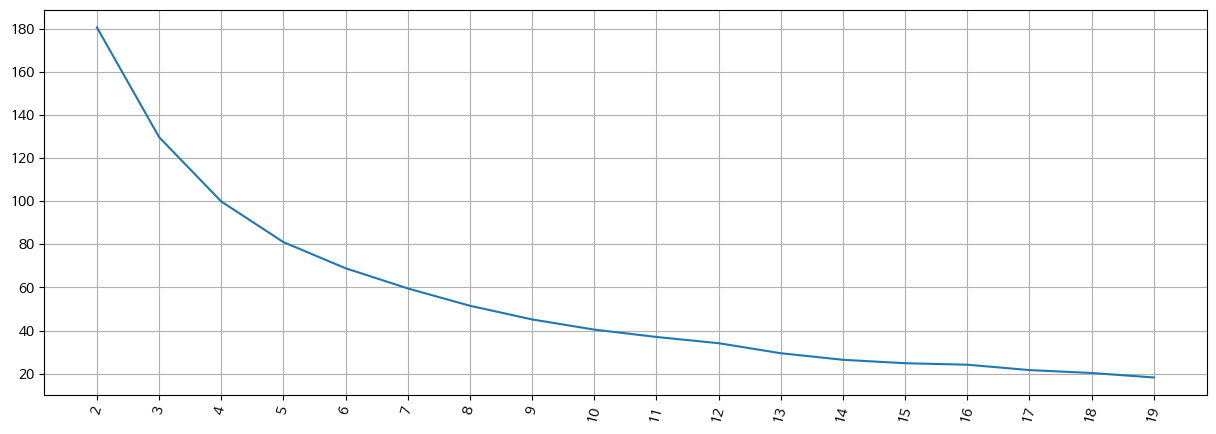

In [163]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_3rd_year)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

실루엣 기법

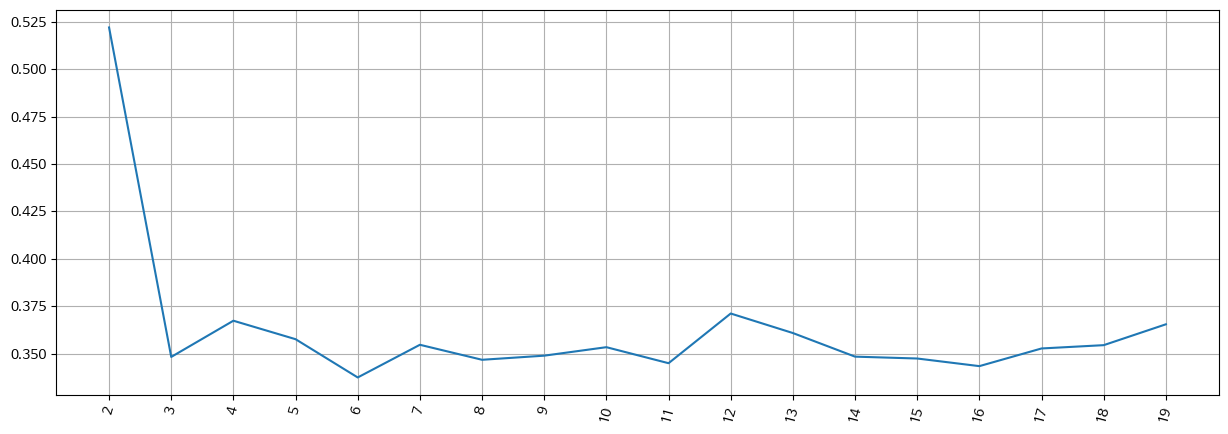

In [164]:
silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X_3rd_year)
        silhouette_score.append(metrics.silhouette_score(X_3rd_year, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

In [165]:
nclust=3
#Fit with k-means
k_means_3rd_year = cluster.KMeans(n_clusters=nclust)
k_means_3rd_year.fit(X_3rd_year)

KMeans(n_clusters=3)

In [166]:
#Extracting labels
target_labels = k_means_3rd_year.predict(X_3rd_year)

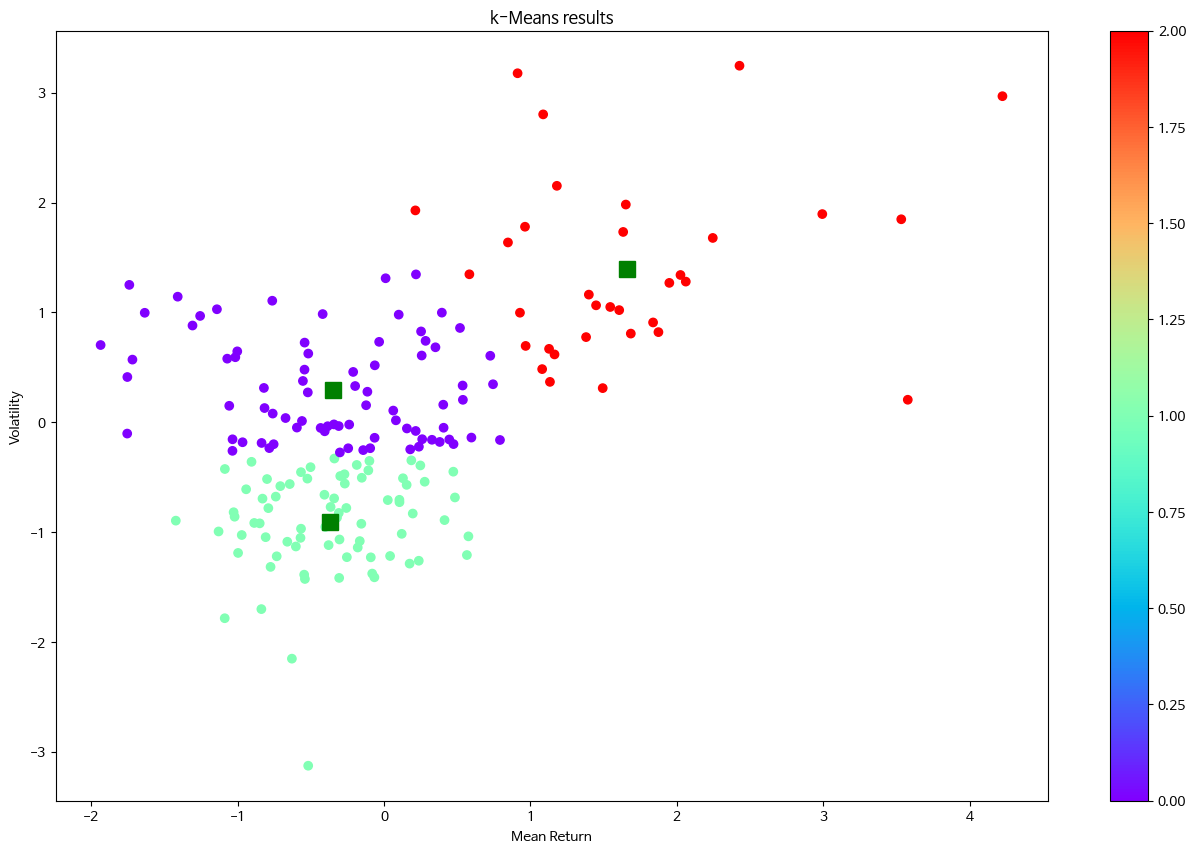

In [167]:
centroids = k_means_3rd_year.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X_3rd_year.iloc[:,0],X_3rd_year.iloc[:,1], c = k_means_3rd_year.labels_, cmap ="rainbow", label = X_3rd_year.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

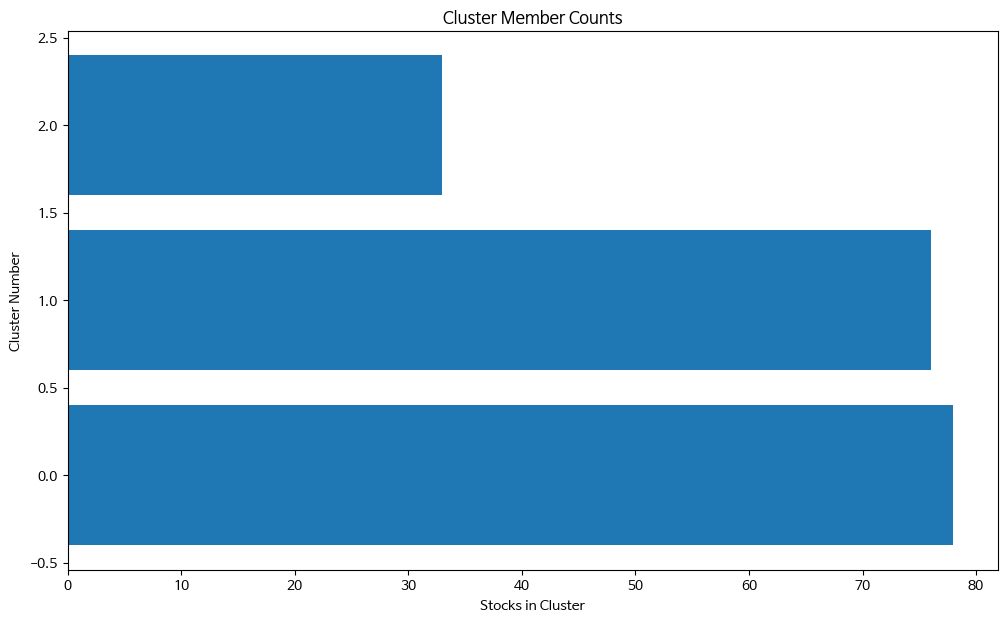

In [168]:
# show number of stocks in each cluster
clustered_series_3rd_year = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.labels_.flatten())
clustered_series_3rd_year = clustered_series_3rd_year[clustered_series_3rd_year != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_3rd_year.value_counts())), # cluster labels, y axis
    clustered_series_3rd_year.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

In [169]:
temp = clustered_series_3rd_year.value_counts()
temp

0    78
1    76
2    33
Name: count, dtype: int64

In [170]:
# all stock with its cluster label (including -1)
clustered_series_3rd_year = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.fit_predict(X_3rd_year).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X_3rd_year.index, data=k_means_3rd_year.fit_predict(X_3rd_year).flatten())
clustered_series_3rd_year = clustered_series_3rd_year[clustered_series_3rd_year != -1]
# get the number of stocks in each cluster
counts_3rd_year = clustered_series_3rd_year.value_counts()

# let's visualize some clusters
cluster_vis_list_3rd_year = list(counts_3rd_year[(counts_3rd_year>1)].index)[::-1]
cluster_vis_list_3rd_year

[2, 1, 0]

In [171]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series_3rd_year.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 3
Pairs to evaluate: 12762


In [172]:
# plot a handful of the smallest clusters
plt.figure(figsize=(24,14))
cluster_vis_list_3rd_year[0:min(len(cluster_vis_list_3rd_year), 1)]

[2]

<Figure size 2400x1400 with 0 Axes>

많은 군집에서 시각화를 통해 주식의 흐름을 먼저 눈으로 판단해보고

최종적으로 수익률이 0% 이상인 클러스터들만 선택.

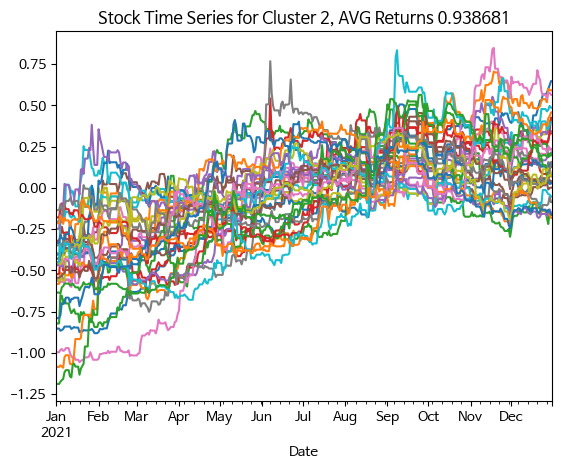

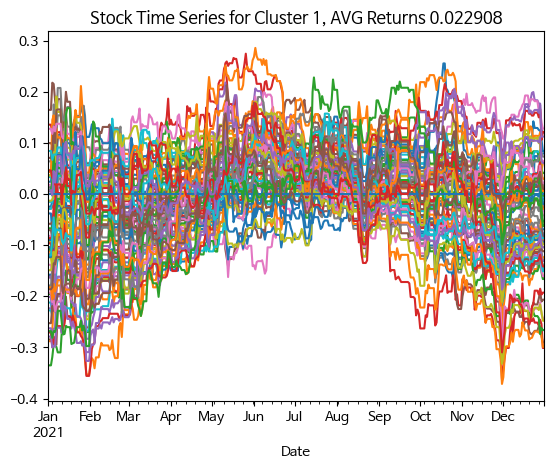

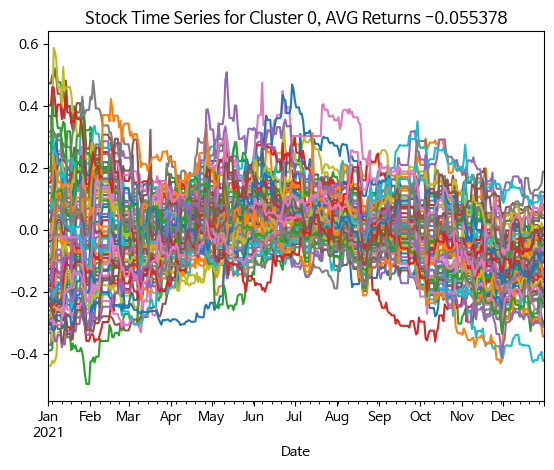

In [173]:
cluster_3rd_year_result = []
for clust in cluster_vis_list_3rd_year:
    tickers = list(clustered_series_3rd_year[clustered_series_3rd_year==clust].index)
    means = np.log(dataset_3rd_year.loc[:, tickers].mean())
    data = np.log(dataset_3rd_year.loc[:, tickers]).sub(means)
    return_value = ((dataset_3rd_year.loc[:, tickers].tail(30).mean()-dataset_3rd_year.loc[:, tickers].head(30).mean())/dataset_3rd_year.loc[:, tickers].head(30).mean()).mean()
    cluster_3rd_year_result.append([clust, return_value])
    data.plot(title='Stock Time Series for Cluster %d, AVG Returns %f' % (clust, return_value), legend=None)
plt.show()

In [174]:
df_c_3rd_year_result = pd.DataFrame(cluster_3rd_year_result, columns=['clust','returns'])
df_c_3rd_year_result = df_c_3rd_year_result[df_c_3rd_year_result['returns'] > 0]
ticker_list_3rd_year = []
for idx,row in df_c_3rd_year_result.iterrows():
    ticker_list_3rd_year = ticker_list_3rd_year + (list(clustered_series_3rd_year[clustered_series_3rd_year==row[0]].index.to_frame(index=False)['Code']))

위에서 나온 A, B, C 군집들에서 공통적으로 속하는 종목을 추리는 과정을 진행한다

In [175]:
print(len(ticker_list_1st_year))
print(len(ticker_list_2nd_year))
print(len(ticker_list_3rd_year))
result = list(set(ticker_list_1st_year) & set(ticker_list_2nd_year) & set(ticker_list_3rd_year))
print(len(result))

85
29
109
10


In [180]:
result # 2nd year을 빼고 하는 방법. # 1년치 데이터만 사용하는 방법. #수익률 0이상 대신 -20이상 대신으로 바꾸는 방법

['A012450',
 'A079550',
 'A138040',
 'A005420',
 'A002710',
 'A006110',
 'A145720',
 'A003230',
 'A003030',
 'A005070']

In [179]:
# print(clustered_series_3rd_year)
# print(clustered_series_2nd_year)
# print(clustered_series_1st_year)

# Louvain 알고리즘, Modularity network

In [2]:
# !pip install networkx python-louvain
import networkx as nx
import community as community_louvain

In [ ]:
'''
# 그래프 생성 (예시)
G = nx.karate_club_graph()  # NetworkX에 내장된 예시 그래프 (Karate Club 그래프)

# Louvain 알고리즘을 사용한 커뮤니티 탐지
partition = community_louvain.best_partition(G)

# 각 노드의 커뮤니티 출력
print("각 노드의 커뮤니티: ", partition)

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 배치 레이아웃
cmap = plt.get_cmap('viridis')  # 색상맵

# 각 커뮤니티에 따른 노드 색상 지정
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=300,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# 그래프 출력
plt.show()

# Modularity 계산
modularity_value = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity_value}")
''''

# 1) 2023년 Modularity

In [5]:
file_path = ('kospi200_stocks.xlsx')
df = pd.read_excel(file_path, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트
data = df.iloc[14:].reset_index(drop=True) # 14번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
data = data.rename(columns={data.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data['date'] = pd.to_datetime(data['date'], errors='coerce')  # 날짜 형식 변환
data = data.set_index(data.columns[0]) # 첫 번째 열을 인덱스로 설정하고 해당 열 제거
data.index = pd.to_datetime(data.index, errors='coerce') # 인덱스를 datetime 형식으로 변환

data.columns.name = 'Code'  # 종목 코드에 이름 설정
data.index.name = 'Date'    # 날짜 인덱스에 이름 설정

# 1년치 데이터 사용
dataset_1st_year = data.loc['2023-01-01':'2023-12-31',:]
dataset_1st_year.head(10)

8,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,55300,75000,435500,821000,151000,160500,59300,48500,276500,35200,...,17000,10450,146500,21900,14350,7390,605000,15400,28900,36450
2023-01-02,55500,75700,446000,827000,157000,160000,61500,47600,272000,34300,...,16600,10352,142000,21450,14450,7150,584000,14750,28900,36150
2023-01-03,55400,75600,440500,803000,159000,159000,62400,49050,272000,35000,...,16300,10499,146500,21150,14800,7260,583000,14450,29600,36550
2023-01-04,57800,81000,443000,794000,160500,160500,62000,50500,274500,36400,...,16500,10645,150000,20900,14700,7310,613000,15150,28900,37050
2023-01-05,58200,81400,433500,808000,159000,163000,61100,53900,278500,39450,...,16500,10401,141000,20950,14600,7440,610000,14700,27850,37150
2023-01-06,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-07,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-08,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-09,60700,86000,464000,812000,164000,166000,64100,57200,289000,40350,...,17050,11036,147000,21300,15150,7710,624000,15500,30200,38300


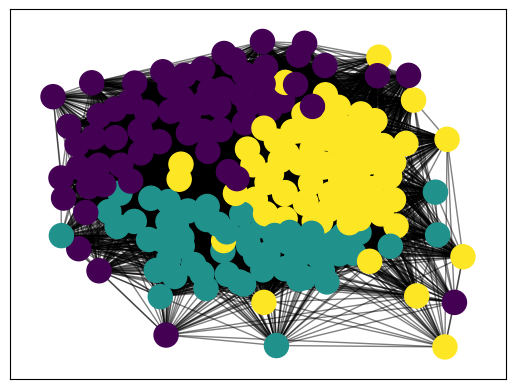

Modularity: 0.14684628669842265


In [8]:
returns_df = dataset_1st_year.copy()

# 2. 상관 행렬 계산 (자산 간 상관관계)
correlation_matrix = returns_df.corr()

# 3. 상관 행렬을 네트워크로 변환
G = nx.Graph()

# 3. 상관 행렬을 네트워크로 변환
G = nx.Graph()

# 상관관계가 높은 자산들 간에만 엣지를 추가 (절대값 사용)
threshold = 0.3  # 임계값 설정. 0.1 / 0.3 / 0.5 해보기.
for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        weight = abs(correlation_matrix.iloc[i, j])  # 상관관계의 절대값 사용
        if weight > threshold:
            G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=weight)

# 만약 그래프에 엣지가 없는 경우, 임의로 연결 추가 (최소 연결 강제)
if G.number_of_edges() == 0:
    print("연결이 없으므로 임의로 최소 연결을 추가합니다.")
    for i in range(len(correlation_matrix)):
        for j in range(i + 1, len(correlation_matrix)):
            G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=0.1)  # 가중치 0.1로 엣지 추가

# 4. Louvain 알고리즘을 사용한 Modularity Clustering
partition = community_louvain.best_partition(G)

# 5. 그래프 시각화
pos = nx.spring_layout(G)  # 노드 배치 레이아웃
cmap = plt.get_cmap('viridis')

# 각 커뮤니티에 따른 노드 색상 지정
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=300,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# 그래프 출력
plt.show()

# 6. Modularity 값 계산
modularity_value = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity_value}")

In [20]:
# partition
# 3개로 분류가 됨.

# 각각의 정보를 리스트에 넣어서.
# 0번에 해당하는 데이터프레임, 1번에 해당하는 데이터프레임, 2번에 해당하는 데이터프레임 따로 만듦.

In [27]:
# 3개의 군집으로 나눌 빈 리스트 생성
cluster_0 = []
cluster_1 = []
cluster_2 = []

# partition 딕셔너리 기준으로 군집 분류
for stock_code, cluster in partition.items():
    if cluster == 0:
        cluster_0.append(stock_code)
    elif cluster == 1:
        cluster_1.append(stock_code)
    elif cluster == 2:
        cluster_2.append(stock_code)

# 각 군집별로 데이터프레임 생성
df_cluster_0 = dataset_1st_year[cluster_0]
df_cluster_1 = dataset_1st_year[cluster_1]
df_cluster_2 = dataset_1st_year[cluster_2]

# 결과 출력 (예시로 각 데이터프레임 확인)
print(df_cluster_0) # 64 columns
print(df_cluster_1) # 57 columns
print(df_cluster_2) # 79 columns

8          A051910 A006400 A259960 A003550 A017670 A018260 A024110 A450080  \
date                                                                         
2023-01-01  600000  591000  168000   78100   47400  123000    9820     NaN   
2023-01-02  604000  602000  164000   76600   47250  120500    9460     NaN   
2023-01-03  601000  605000  166500   75500   46950  120000    9560     NaN   
2023-01-04  601000  603000  166000   76300   47350  120000    9730     NaN   
2023-01-05  581000  583000  165500   76500   47100  120500   10000     NaN   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-12-27  486000  455500  189400   83100   49250  168700   11740  171600   
2023-12-28  499000  472000  193600   85900   50100  170000   11860  188500   
2023-12-29  499000  472000  193600   85900   50100  170000   11860  188500   
2023-12-30  499000  472000  193600   85900   50100  170000   11860  188500   
2023-12-31  499000  472000  193600   85900   50100  170000   118

## K-ratio = 누적수익률의 기울기 / 표준오차
* 모멘텀 지표
* 하락하다 상승, 횡보하다 상승, 상승하다 하락 하는 등의 종목이 아닌, 꾸준히 상승한 종목 선별가능.

In [33]:
import statsmodels.api as sm

# 데이터프레임을 리스트로 저장
clusters = [df_cluster_0, df_cluster_1, df_cluster_2]
top_20_stocks = {}

# 각 클러스터별로 K-ratio 계산 및 랭킹 매기기
for idx, df_cluster in enumerate(clusters):
    price_pivot = df_cluster  # 각 클러스터 데이터프레임
    ticker_list = price_pivot.columns  # 종목코드 리스트

    # 수익률 계산
    ret = price_pivot.pct_change().iloc[1:]
    ret_cum = np.log(1 + ret).cumsum()

    x = np.array(range(len(ret)))  # X축: 기간
    k_ratio = {}

    # 각 종목에 대해 K-ratio 계산
    for ticker in ticker_list:
        try:
            y = ret_cum[ticker].values  # 누적수익률
            reg = sm.OLS(y, sm.add_constant(x)).fit()  # OLS 회귀분석
            res = float(reg.params[1] / reg.bse[1])  # K-ratio = 기울기 / 표준오차
        except:
            res = np.nan  # 오류 발생 시 NaN 처리

        k_ratio[ticker] = res

    # K-ratio를 데이터프레임으로 변환
    k_ratio_bind = pd.DataFrame.from_dict(k_ratio, orient='index').reset_index()
    k_ratio_bind.columns = ['종목코드', 'K_ratio']

    # K-ratio에 따라 종목을 랭킹
    k_ratio_bind['K_ratio_rank'] = k_ratio_bind['K_ratio'].rank(axis=0, ascending=False)

    # 상위 20개 종목 추출
    top_20 = k_ratio_bind[k_ratio_bind['K_ratio_rank'] <= 20]
    top_20_stocks[f'cluster_{idx}'] = top_20

# 결과 출력: 각 군집별 상위 20개 종목
print(top_20_stocks['cluster_0'])
print(top_20_stocks['cluster_1'])
print(top_20_stocks['cluster_2'])


       종목코드    K_ratio  K_ratio_rank
4   A017670  14.425141           6.0
5   A018260  24.655541           3.0
6   A024110  31.024844           1.0
8   A079550  19.110280           5.0
10  A006800   3.570059          20.0
11  A029780  10.584750           9.0
12  A003230  29.146375           2.0
15  A138930   9.555298          10.0
18  A185750  22.897204           4.0
20  A139130  14.125050           7.0
24  A032830   8.824227          11.0
25  A316140   6.095849          13.0
33  A175330  11.410370           8.0
35  A000120   5.836744          14.0
43  A105560   3.895023          17.0
46  A030200   5.113583          15.0
51  A088350   4.177801          16.0
54  A012750   3.628195          19.0
56  A280360   3.840579          18.0
62  A009240   6.287960          12.0
       종목코드    K_ratio  K_ratio_rank
1   A000270  14.124314           7.0
2   A012330  15.455639           5.0
3   A003670  13.110548          10.0
5   A012450  19.728373           3.0
6   A329180  11.019709          14.0
7

In [35]:
# 상위 20개의 종목들을 리스트로 합침
top_20_all_clusters = []
for cluster_df in top_20_stocks.values():
    top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

# 중복 제거
top_20_all_clusters = list(set(top_20_all_clusters))

# dataset_1st_year에서 상위 20개 종목들만 추출
dataset_1st_year_momentum = dataset_1st_year[top_20_all_clusters]
dataset_1st_year_momentum

8,A009420,A010620,A012450,A329180,A185750,A003670,A012750,A267260,A022100,A012330,...,A001430,A003030,A139130,A272210,A017670,A009540,A002710,A032830,A069260,A029780
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,17800,84500,76138,116000,78351,180000,59300,42500,6250,200500,...,16300,146500,6990,10550,47400,70700,9350,71000,20000,29550
2023-01-02,17600,81400,76138,117500,76729,191500,57800,40450,6100,202500,...,15400,142000,6750,10450,47250,71000,9340,70400,19100,28900
2023-01-03,17250,82500,73862,114500,75966,187500,56700,40250,6130,202000,...,15400,146500,6850,10400,46950,69500,9450,69400,18900,29000
2023-01-04,17650,78100,74276,109000,76347,187500,57900,38650,6130,203000,...,15550,150000,7020,10700,47350,74400,9430,70900,19250,29200
2023-01-05,17450,74900,69103,106000,76347,183500,57200,37500,5900,207000,...,16350,141000,7210,10450,47100,73400,9350,71000,19100,29950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,44300,82000,128793,125500,133000,357500,59000,80400,71700,230000,...,24200,235000,8400,17220,49250,116800,58000,68600,21350,32150
2023-12-28,44300,84900,128793,129000,130900,359000,60000,82200,74200,237000,...,24850,240000,8490,17360,50100,120900,58800,69100,21500,32350
2023-12-29,44300,84900,128793,129000,130900,359000,60000,82200,74200,237000,...,24850,240000,8490,17360,50100,120900,58800,69100,21500,32350


In [40]:
import pandas as pd

# dataset_1st_year_momentum의 종목 코드를 가져옴
momentum_tickers = dataset_1st_year_momentum.columns.tolist()

# data에서 2024년 10월 7일까지의 수정 종가 데이터를 추출
# 종목은 momentum_tickers에 해당하는 것만 가져옴
data_momentum = data[momentum_tickers].loc['2023-01-01':'2024-10-07']

# 수익률 계산: 수정 종가의 일별 변화율로 수익률을 계산
momentum_returns = data_momentum.pct_change().dropna()

# 동일 비중으로 투자했을 때의 포트폴리오 수익률
equal_weight_returns = momentum_returns.mean(axis=1)

# 누적 수익률 계산
cumulative_returns = (1 + equal_weight_returns).cumprod() - 1

# 2024년 10월 7일 기준 최종 누적 수익률 출력
final_cumulative_return = cumulative_returns.iloc[-1]
print(f"2024년 10월 7일까지 동일 비중 투자 누적 수익률: {final_cumulative_return * 100:.2f}%")

# 결과 출력 (누적 수익률 시계열)
print(cumulative_returns)

2024년 10월 7일까지 동일 비중 투자 누적 수익률: 98.85%
date
2023-01-02   -0.019257
2023-01-03   -0.022054
2023-01-04   -0.013928
2023-01-05   -0.016355
2023-01-06   -0.008720
                ...   
2024-10-03    0.932160
2024-10-04    0.940408
2024-10-05    0.940408
2024-10-06    0.940408
2024-10-07    0.988504
Length: 645, dtype: float64


## KOSPI200 벤치마크 데이터

In [71]:
!pip install yfinance
import yfinance as yf

# 코스피 200 지수의 티커 코드
ticker = "^KS200"

# 시작일과 종료일 설정
start_date = "2022-12-29" #주말이 포함되어 있기 때문에 작년정보까지 확인.
end_date = "2024-10-07"

# 코스피 200 지수의 데이터를 가져오기
ks= yf.download(ticker, start=start_date, end=end_date, interval='1d')
kospi_200 = ks['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [73]:
# 12월 29일 수정종가를 다음해 1월 1일 수정종가로 변경. Dataguide 정책에 따름.
index_list = kospi_200.index.tolist()
index_list[0] = pd.to_datetime('2023-01-01')
kospi_200.index = index_list
print(kospi_200.head())

2023-01-01    291.100006
2023-01-02    289.790009
2023-01-03    289.579987
2023-01-04    295.980011
2023-01-05    297.869995
Name: Adj Close, dtype: float64


In [75]:
# 일간 수익률 계산 (수정종가의 퍼센트 변화)
kospi200_returns = kospi_200.pct_change().dropna()
# 누적 수익률 계산
kospi200_cumulative_returns = (1 + kospi200_returns).cumprod() - 1
kospi200_cumulative_returns

2023-01-02   -0.004500
2023-01-03   -0.005222
2023-01-04    0.016764
2023-01-05    0.023257
2023-01-06    0.035830
                ...   
2024-09-26    0.224459
2024-09-27    0.215836
2024-09-30    0.184335
2024-10-02    0.170457
2024-10-04    0.173961
Name: Adj Close, Length: 430, dtype: float64

In [79]:
cumulative_returns #코스피200과 포트폴리오 끝나는 일자가 맞지 않는 이유는 Dataguide 주말(공휴일) 처리 정책 때문. yfinance = 공휴일 제거 / dataguide = 이전 평일 값으로 대체.

date
2023-01-02   -0.019257
2023-01-03   -0.022054
2023-01-04   -0.013928
2023-01-05   -0.016355
2023-01-06   -0.008720
                ...   
2024-10-03    0.932160
2024-10-04    0.940408
2024-10-05    0.940408
2024-10-06    0.940408
2024-10-07    0.988504
Length: 645, dtype: float64

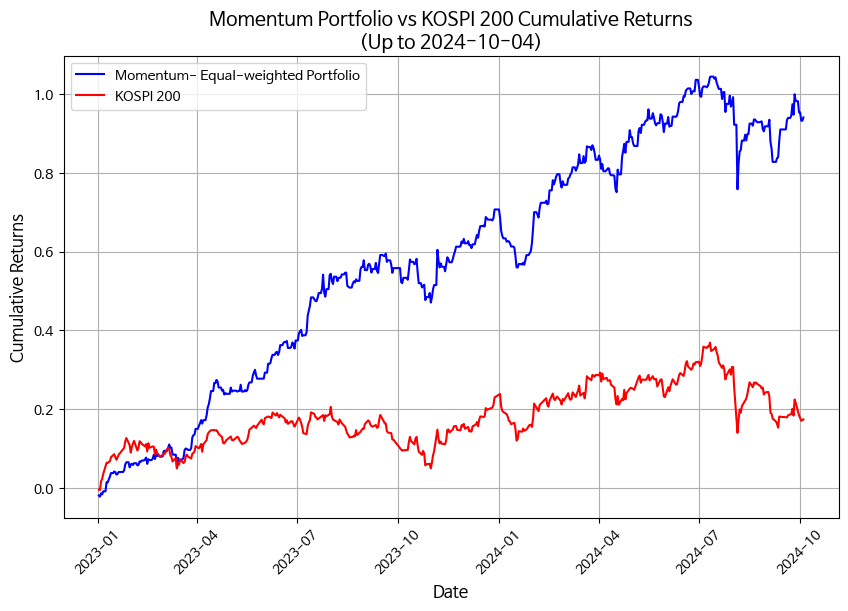

In [80]:
# 그래프 설정
plt.figure(figsize=(10, 6))
# 동일 비중 포트폴리오의 누적 수익률 시각화
plt.plot(cumulative_returns.loc['2023-01-02':'2024-10-04'], label='Momentum- Equal-weighted Portfolio', color='blue')
# 코스피200 누적 수익률 시각화
plt.plot(kospi200_cumulative_returns.loc['2023-01-02':'2024-10-04'], label='KOSPI 200', color='red')

# 그래프 제목 및 축 설정
plt.title('Momentum Portfolio vs KOSPI 200 Cumulative Returns\n(Up to 2024-10-04)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
# 날짜 라벨 회전
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

벤치마크는 크게 상회했으나 1% 수익률.

모멘텀 지표가 아닌 밸류지표로도 해볼까. (PER, PBR, EPS 등.)